In [50]:
import numpy as np
from scipy.optimize import minimize
import l2distance

import matplotlib.pyplot as plt

In [51]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

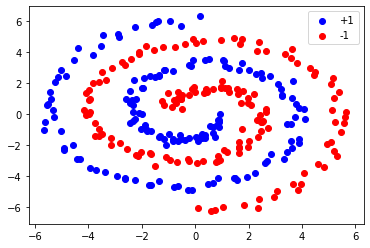

In [52]:
xTr,yTr,xTe,yTe=spiraldata()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$

In [53]:
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    ## Solution Start
    if kerneltype == "linear":
        K = X.dot(Z.T)
    elif kerneltype == "polynomial" or kerneltype == "poly":
        K = np.power((X.dot(Z.T) + 1), kpar)
    else:
        K = np.exp(-kpar*np.square(l2distance.l2distance(X,Z)))
    ## Solution End
    
    return K

In [54]:
# use SLSQP
# student implements this for SLSQP
def generate_calculate_dual(yTr, K):
    def calculate_dual(alpha):
        temp = alpha * yTr
        return temp.reshape(1, -1) @ K @ temp / 2 - np.sum(alpha)
    return calculate_dual

def generate_equality_constraint(yTr):
    def equality_constraint(alpha):
        return np.sum(alpha * yTr)
    return equality_constraint


from scipy.optimize import Bounds
def generate_bound(alpha, C):
    return Bounds(np.zeros_like(alpha), np.ones_like(alpha)*C)

In [55]:
alpha = np.zeros_like(yTr)
K = computeK('rbf', xTr, xTr, kpar=1)
equality_constraint = generate_equality_constraint(yTr)
bounds = generate_bound(alpha, 10)
objective = generate_calculate_dual(yTr, K)

In [56]:
eq_cons = {'type': 'eq', 'fun': equality_constraint}
sol = minimize(objective, alpha, method='SLSQP', constraints=eq_cons,bounds=bounds, options={'ftol':1e-9, 'disp':True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -37.40503611173173
            Iterations: 97
            Function evaluations: 29301
            Gradient evaluations: 97


In [57]:
alpha_sol = sol.x

In [58]:
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """

    ## Solution Start
    idx = (np.abs(alpha-(C/2))).argmin()
    y_i = yTr[idx]
    bias = y_i - np.sum(alpha*yTr*K[idx])
    ## Solution End
    
    return bias

In [59]:
bias_sol = recoverBias(K, yTr, alpha_sol, 10)

In [60]:
# Build classifier
interm = alpha_sol*yTr
svmclassify = lambda x: np.sign(computeK('rbf', xTr, x, 1).transpose().dot(interm) + bias_sol)

In [61]:
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

Training error: 0.0000
Testing error: 0.0067


In [62]:
from visclassifier import visclassifier

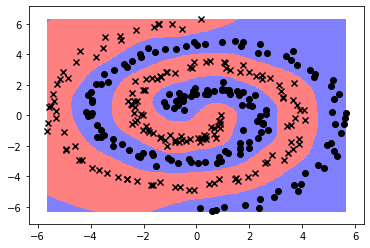

In [63]:
visclassifier(svmclassify, xTr, yTr)